<a href="https://colab.research.google.com/github/andres-eric/andres-eric/blob/main/NUTRESA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:

from sklearn.naive_bayes import GaussianNB
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import warnings
import joblib


In [230]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [231]:

import sys
sys.path.append('/content/drive/MyDrive/ciencia de datos/Nutresa')
import funciones_m

import sys
import os

# Assuming 'funciones_eda.py' is located one level up from your current working directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import funciones_eda

import importlib
importlib.reload(funciones_eda)


import funciones_m

import importlib
importlib.reload(funciones_m)

<module 'funciones_m' from '/content/drive/MyDrive/ciencia de datos/Nutresa/funciones_m.py'>

In [232]:
import sys
import os

# Assuming 'funciones_eda.py' is located one level up from your current working directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import funciones_eda

In [233]:
import sqlite3
import pandas as pd

db_path = '/content/drive/MyDrive/ciencia de datos/Nutresa/data_base_prueba_CN.db'

conn = sqlite3.connect(db_path)

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tablas en la base de datos:")
print(tables)

query = "SELECT * FROM data;"
df = pd.read_sql(query, conn)

# Cerrar la conexión
conn.close()

Tablas en la base de datos:
   name
0  data


In [234]:
!pip install category_encoders

In [235]:
import sys
!{sys.executable} -m pip install category_encoders

In [236]:
from category_encoders import TargetEncoder

## Definición de Objetivo notebook
construir un modelo de recomendación semanal que, basado en los datos históricosde ventas, genere una lista de productos con la mayor probabilidad de compra en un período específico para cada cliente.

## Definición de Objetivo notebook
construir un modelo de recomendación semanal que, basado en los datos históricosde ventas, genere una lista de productos con la mayor probabilidad de compra en un período específico para cada cliente.

### ANALISIS EXPLORATORIO

In [237]:
funciones_eda.datos_generales(df)

El dataframe tiene 2713148 filas y 21 columnas


In [238]:
funciones_eda.datos_generales(df)

El dataframe tiene 2713148 filas y 21 columnas


In [239]:
funciones_eda.datos_generales(df)

El dataframe tiene 2713148 filas y 21 columnas


### NULLOS

In [240]:
df.isnull().sum().sum()

8600

In [241]:
funciones_eda.nullos(df).head(1)

la cantidad de nulos es: 8600


,index,ORDER_DATE,SALES_ORDER_ID,CUSTOMER_ID,IS_DIRECT,DIST_CHANNEL_ID,DIST_CHANNEL_NAME,SUB_DIST_CHANNEL_ID,SUB_DIST_CHANNEL_NAME,TIPOL_TRANS,...,PRODUCT_ID,SECTOR_ID,SECTOR_NAME,BRAND_ID,BRAND_NAME,CATEGORY_ID,CATEGORY_NAME,SUB_CATEGORY_ID,SUB_CATEGORY_NAME,QTY
1669566,1669566,2024-04-29 00:00:00,7193733629,29438,1,N,Alternativo,EC,Comercio Electronico,None,...,55,1,Carnico,001,Zenú,04,Alimentos Larga vida,21,LV Vegetales,3.0


In [242]:
porcentajde_de_nullos=round(df.isnull().sum().sum()/len(df)*100,4)
porcentajde_de_nullos

0.317

In [243]:
df = df.dropna()

### OUTLIERS

In [244]:
df_2=funciones_eda.eliminar_outliers_iqr(df, 'QTY', multiplicador=1.5)

### CAMBIO DE TIPO FECHA

In [245]:
funciones_eda.transfor_fecha(df,['ORDER_DATE'])
df['Semana'] = df['ORDER_DATE'].dt.isocalendar().week

### FILTRO DATA SET POR MODELOS DE ATENCION Y VARIABLES CLIENTE

In [246]:
df=df[['QTY','Semana','ORDER_DATE','CUSTOMER_ID','PRODUCT_ID','DIST_CHANNEL_NAME','SUB_DIST_CHANNEL_NAME','TIPOL_TRANS','IS_DIRECT','TIPOL_TRANS_NAME','SECTOR_NAME','BRAND_NAME','CATEGORY_NAME','SUB_CATEGORY_NAME']]

In [247]:
directa=df[df.IS_DIRECT=='1']
no_directa=df[df.IS_DIRECT=='0']

directa_ = directa.copy()
no_directa = no_directa.copy()


Filtrar el dataset por IS_DIRECT, ya que permite adaptar las recomendaciones en función del tipo de atención. el cual puede ayudar a personalizar el “Pedido sugerido”

In [248]:
funciones_eda.datos_generales(directa)

El dataframe tiene 1039316 filas y 14 columnas


In [249]:
funciones_eda.datos_generales(no_directa)

El dataframe tiene 1669532 filas y 14 columnas


### ANALITICA DESCRIPTIVA

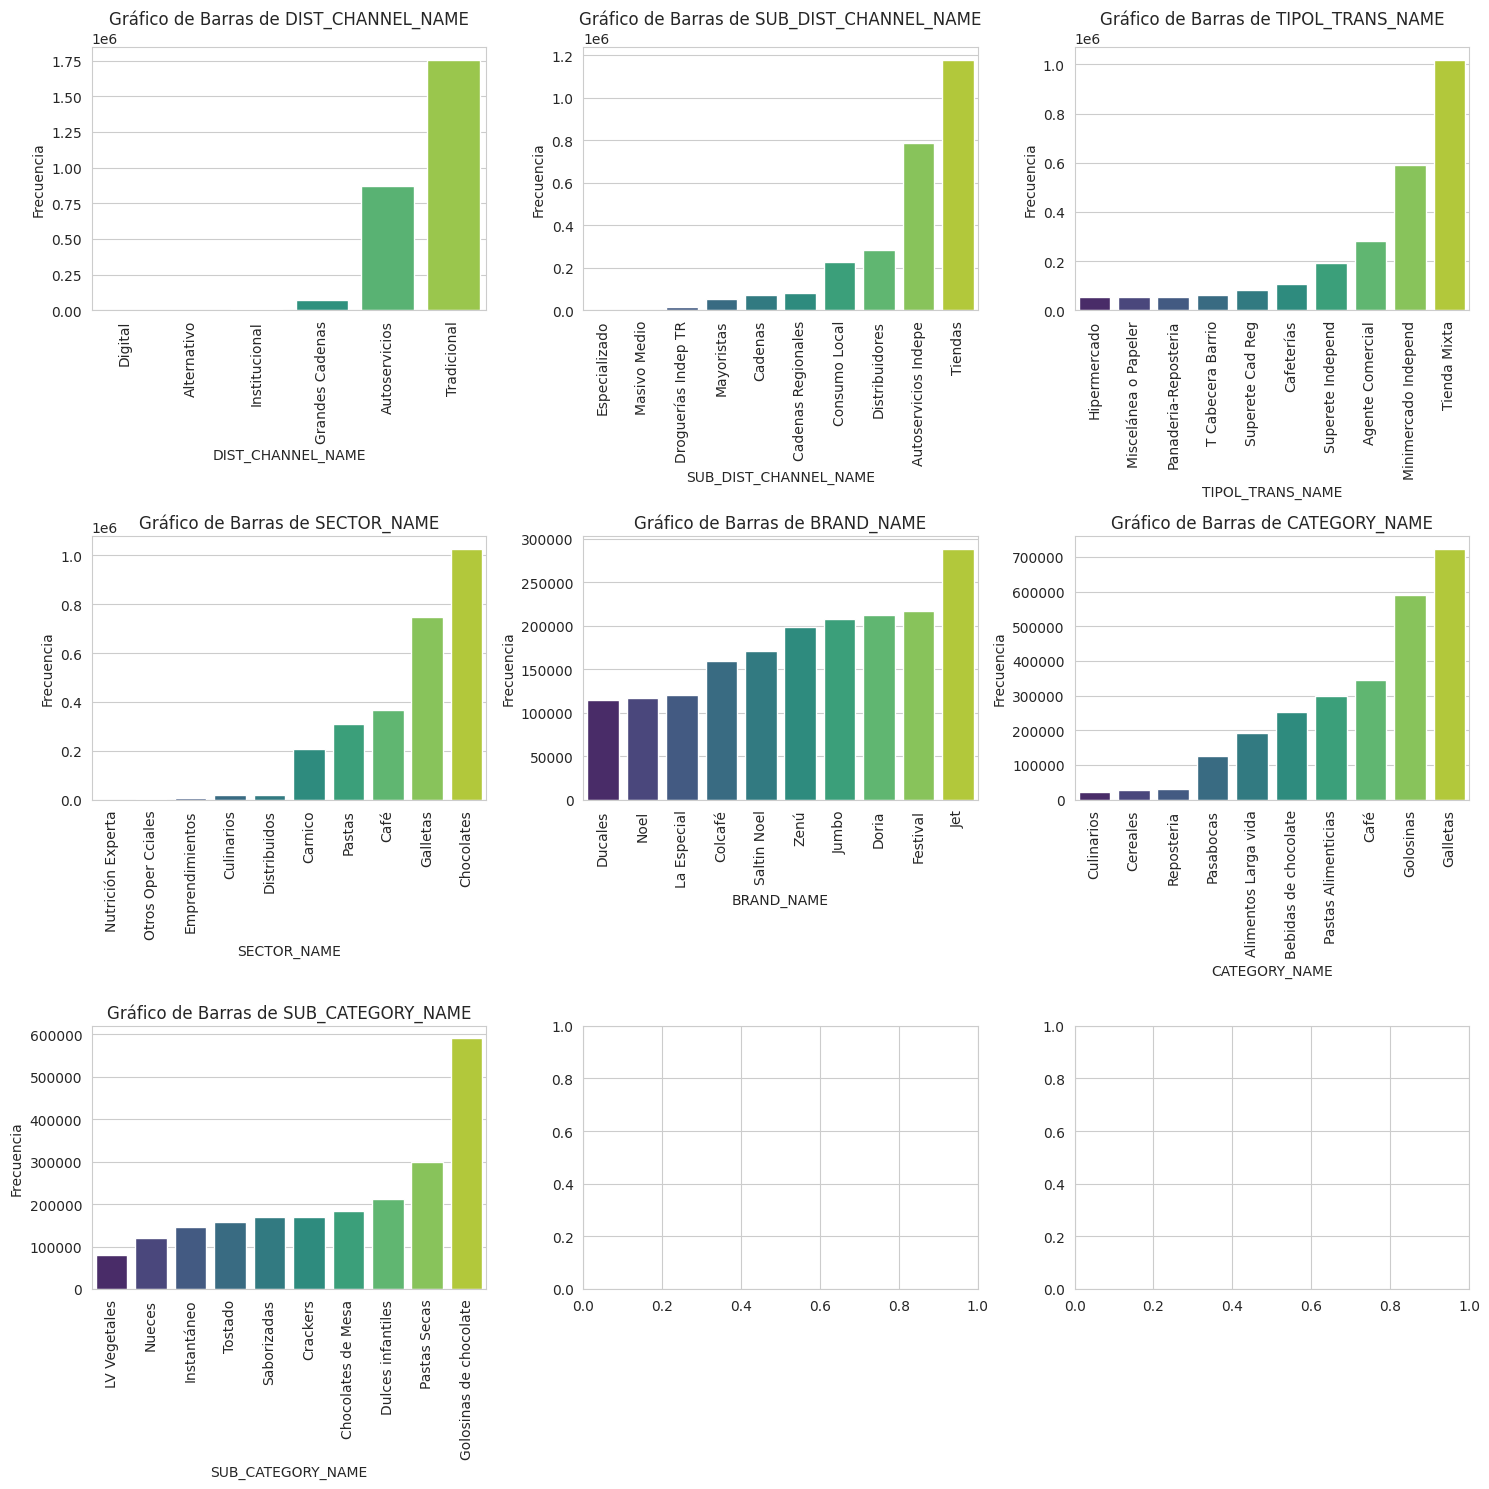

In [250]:
funciones_eda.graficar_barras_columnas(df,['DIST_CHANNEL_NAME','SUB_DIST_CHANNEL_NAME',\
    'TIPOL_TRANS_NAME',\
    'SECTOR_NAME','BRAND_NAME','CATEGORY_NAME','SUB_CATEGORY_NAME'])

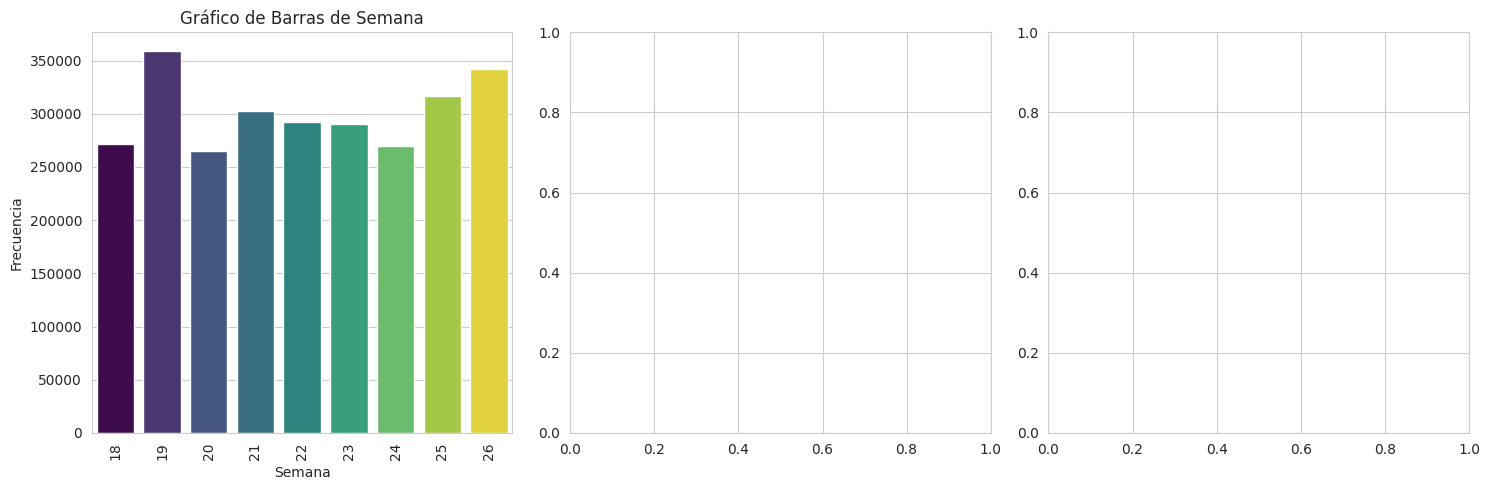

In [251]:
funciones_eda.graficar_barras_columnas(df,['Semana'])

- DIST_CHANNEL_NAME: Las categorías "Autosevicios" y "Tradicional" tienen la frecuencia más alta, con "Tradicional" ligeramente más alto que "Autosevicios"

- SUB_DIST_CHANNEL_NAME: La categoría "Tiendas" destaca por tener la mayor frecuencia, seguida de "Servicios Indepe"

- TIPOL_TRANS_NAME: "Tienda Mixta" es la categoría con mayor frecuencia, seguida de "Minimercado Independ" y "Agente Comercial".

apartir de el analisis de los graficos de frecuencia por canal, sector, marca y categoría, se puede hacer observaciones para mejorar generalizar el modelo de recomendacion y hebitar el ruido:

Los canales "Tradicional" y "Autosevicios" en DIST_CHANNEL_NAME, junto con "Tiendas" en SUB_DIST_CHANNEL_NAME y "Tienda Mixta" en TIPOL_TRANS_NAME, concentran la mayoría de las transacciones, tambien  los sectores de "Chocolates", "Galletas" y "Café" son los más frecuentes en ventas, lo que sugiere una fuerte demanda en estos segmentos.

tambien las categorías de baja frecuencia, como "Digital" en DIST_CHANNEL_NAME, y sectores como "Nutrición Experta" o marcas menos populares como "Ducales" y "Noel", aportan menor volumen de datos y podrían introducir ruido en el modelo.

por otro lado La variabilidad en los patrones de compra entre los canales (por ejemplo, el comportamiento de compra en "Tradicional" vs. "Autosevicios") sugiere que puede ser beneficioso crear submodelos especializados para cada canal de alto volumen lo cual permite recomendaciones más personalizadas y efectivas, sin embargo es una sugerencia que aplica para posteriores evaluaciones.

AGRUPAR DATOS

In [252]:
agrupado_d=funciones_eda.calcular_probabilidad_compra(directa_)

In [253]:
agrupado_d['PRODUCT_ID'] = agrupado_d['PRODUCT_ID'].astype(float)
agrupado_d['CUSTOMER_ID'] = agrupado_d['CUSTOMER_ID'].astype(float)

In [254]:
agrupado_d['se_vende'] = (agrupado_d['probabilidad_compra_producto'] >= 0.5).astype(int)


In [255]:
agrupado_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768321 entries, 0 to 768320
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   CUSTOMER_ID                   768321 non-null  float64
 1   PRODUCT_ID                    768321 non-null  float64
 2   Semana                        768321 non-null  UInt32 
 3   DIST_CHANNEL_NAME             768321 non-null  object 
 4   SUB_DIST_CHANNEL_NAME         768321 non-null  object 
 5   TIPOL_TRANS                   768321 non-null  object 
 6   BRAND_NAME                    768321 non-null  object 
 7   SECTOR_NAME                   768321 non-null  object 
 8   QTY                           768321 non-null  float64
 9   total_compras_cliente         768321 non-null  float64
 10  probabilidad_compra_producto  768321 non-null  float64
 11  se_vende                      768321 non-null  int64  
dtypes: UInt32(1), float64(5), int64(1), object(5

### MODELOS

In [256]:
modelos_clasificacion = [
    'SVC()',
    'RandomForestClassifier()',
    'DecisionTreeClassifier()',
    'XGBClassifier()',
    'LGBMClassifier()',
    'AdaBoostClassifier()',
    'GradientBoostingClassifier()',
    'LogisticRegression()',
    'HistGradientBoostingClassifier()',
    'KNeighborsClassifier()'
]

In [257]:
agrupado_d=agrupado_d[['CUSTOMER_ID','PRODUCT_ID','Semana','DIST_CHANNEL_NAME','SUB_DIST_CHANNEL_NAME','BRAND_NAME','SECTOR_NAME','se_vende']]

In [258]:
agrupado_d.head(3)

,CUSTOMER_ID,PRODUCT_ID,Semana,DIST_CHANNEL_NAME,SUB_DIST_CHANNEL_NAME,BRAND_NAME,SECTOR_NAME,se_vende
0,29432.0,102.0,20,Grandes Cadenas,Cadenas,La Especial,Chocolates,0
1,29432.0,102.0,21,Grandes Cadenas,Cadenas,La Especial,Chocolates,0
2,29432.0,102.0,22,Grandes Cadenas,Cadenas,La Especial,Chocolates,0


### DATOS NUEVOS PARA EL MODELO

In [259]:
datos_nuevos = agrupado_d[agrupado_d.CUSTOMER_ID.isin([33074, 33116,33675])].copy()
datos_nuevos['Semana'] = 27


In [260]:
datos_nuevos = datos_nuevos.drop(columns=['se_vende'])

GET DUMMIES

In [261]:
agrupado_d=pd.get_dummies(agrupado_d,drop_first=1)

In [262]:
datos_nuevos_d=pd.get_dummies(datos_nuevos,drop_first=1)

MODELO

In [263]:
modelo=['DecisionTreeClassifier()']

In [264]:
probabilidades_df = funciones_m.modelos_func_clasificacion(agrupado_d, modelo, 'se_vende', 'se_vende')

In [265]:
probabilidades_df

,CUSTOMER_ID,PRODUCT_ID,Semana,probabilidad_compra,model
0,33888.0,220.0,23,0.062333,DecisionTreeClassifier
1,34770.0,1502.0,26,0.609853,DecisionTreeClassifier
2,33675.0,233.0,23,0.079903,DecisionTreeClassifier
3,34046.0,331.0,25,0.055945,DecisionTreeClassifier
4,34393.0,55.0,25,0.311024,DecisionTreeClassifier
...,...,...,...,...,...
153660,31867.0,337.0,18,0.600334,DecisionTreeClassifier
153661,29605.0,1180.0,23,0.600334,DecisionTreeClassifier
153662,32174.0,22.0,22,0.229613,DecisionTreeClassifier
153663,35825.0,12.0,26,0.600334,DecisionTreeClassifier


PRUEBA DE MODELO NUEVOS DATOS

carga de modelo

In [266]:
# Ruta en Google Drive
#db_path = '/content/drive/MyDrive/ciencia de datos/Nutresa/'
db_path = '/content/drive/MyDrive/ce/EXCEL/'

# Cargar el modelo y el escalador guardados
modelo_cargado = joblib.load(f'{db_path}DecisionTreeClassifier_entrenado.pkl')  # Cambia a tu modelo específico si usaste otro
scaler_cargado = joblib.load(f'{db_path}scaler.pkl')
columnas_entrenamiento = joblib.load(f'{db_path}columnas_entrenamiento.pkl')


In [267]:
datos_nuevos = datos_nuevos.reindex(columns=columnas_entrenamiento, fill_value=0)

In [268]:
# Escalar el conjunto de datos utilizando el escalador cargado
datos_nuevos_scaled = scaler_cargado.transform(datos_nuevos)

In [269]:
if hasattr(modelo_cargado, "predict_proba"):
    probabilidades_nuevas = modelo_cargado.predict_proba(datos_nuevos_scaled)[:, 1]  # Probabilidad de la clase positiva (por ejemplo, compra)
else:
    raise ValueError("El modelo cargado no admite predict_proba.")

In [271]:
# Crear el DataFrame con los resultados de probabilidades
probabilidades_df_nuevas = pd.DataFrame({
    'CUSTOMER_ID': datos_nuevos['CUSTOMER_ID'].values,  # Ajusta los nombres de columna según tus datos
    'PRODUCT_ID': datos_nuevos['PRODUCT_ID'].values,
    'Semana': datos_nuevos['Semana'].values,
    'probabilidad_compra': probabilidades_nuevas
})

# Mostrar las primeras filas para verificar
probabilidades_df_nuevas


,CUSTOMER_ID,PRODUCT_ID,Semana,probabilidad_compra
0,33074.0,1.0,27,0.600334
1,33074.0,103.0,27,0.600334
2,33074.0,103.0,27,0.600334
3,33074.0,1109.0,27,0.600334
4,33074.0,1109.0,27,0.600334
...,...,...,...,...
1732,33675.0,98.0,27,0.600334
1733,33675.0,986.0,27,0.600334
1734,33675.0,986.0,27,0.600334
1735,33675.0,999.0,27,0.600334


In [272]:
# Especifica la ruta donde deseas guardar el archivo en Google Drive
ruta_guardado = '/content/drive/MyDrive/ciencia de datos/Nutresa/probabilidades_df_nuevas.csv'

# Guardar el DataFrame en formato CSV
probabilidades_df_nuevas.to_csv(ruta_guardado, index=False)

print("El archivo se ha guardado correctamente en Google Drive.")

El archivo se ha guardado correctamente en Google Drive.
